参考サイト：https://qiita.com/bokuikkun/items/1beb699d4eb9413e6038

In [18]:
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from scipy import io


In [19]:
vortall_mat = io.loadmat('./CYLINDER_ALL.mat')
X = vortall_mat['VORTALL']
time_steps = X.shape[1]
width = 199
height = 449

MovieWriter imagemagick unavailable; using Pillow instead.


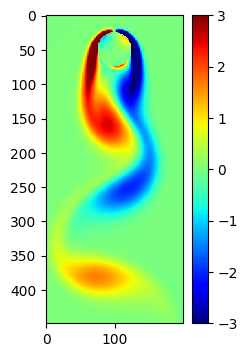

In [20]:
### Animation of the original data
fig, ax = plt.subplots(figsize=(2.5, 4))
im = ax.imshow(
    X[:,0].reshape(height, width),
    cmap="jet",
    norm=mcolors.Normalize(vmin=-3., vmax=3.),
    interpolation='nearest'
)
plt.colorbar(im, ax=ax)

### Update function for animation
def update(frame):
    im.set_array(X[:,frame].reshape(height, width))
    return [im]

ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(time_steps),
    blit=True,
    interval=50
)
ani.save('flow_field_animation.gif', writer='imagemagick')

In [21]:
def DMD(X, Xprime, rank, exact = True):
    ### Compute the SVD of X
    U, S, Vh = np.linalg.svd(X, full_matrices=False)
    Ur = U[:,:rank]
    Sr = np.diag(S[:rank])
    Vhr = Vh[:rank, :]

    ### Obtain Atilde by computing the pseudo-inverse of X
    Atilde = np.linalg.solve(Sr, (Ur.T @ Xprime @ Vhr.T))

    ### The Spectral decomposition of Atilde
    Lambda, W = np.linalg.eig(Atilde)
    Lambda = np.diag(Lambda)

    ### Reconstructed the high-demensional DMD modes
    Phi = Xprime @ np.linalg.solve(Sr.T, Vhr).T @ W if exact else Ur @ W
    x1tilde = Sr @ Vhr[:,0]
    b = np.linalg.solve(W @ Lambda, x1tilde)
    return Phi, Lambda, b

C:\Users\hamma\AppData\Local\Temp\ipykernel_3484\1419009219.py:13: UserWarning: Adding colorbar to a different Figure <Figure size 250x400 with 2 Axes> than <Figure size 1200x400 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(im, ax=ax1)
MovieWriter imagemagick unavailable; using Pillow instead.


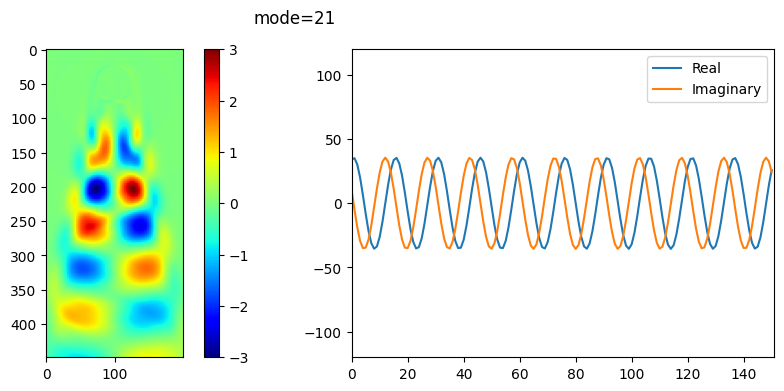

In [22]:
### Animation of the DMD modes (Diagnostics)
vmax = 10**-2
Phi, Lambda, b = DMD(X[:,:-1], X[:,1:], 21)

### Plot DMD modes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
im1 = ax1.imshow(
    Phi[:,0].real.reshape(height, width),
    cmap="jet",
    norm=mcolors.Normalize(vmin=-vmax, vmax=vmax),
    interpolation='nearest'
)
plt.colorbar(im, ax=ax1)

### ax2 customize
ax2.set_xlim(0, time_steps)
ax2.set_ylim(-120, 120)

### Plot oscillation frequencies
omega = np.log(np.diag(Lambda))
time_dynamics = np.zeros((len(b), time_steps), dtype='complex')
for t in range(time_steps):
    time_dynamics[:,t] = np.diag(b) @ np.exp(omega * t).T
line_real, = ax2.plot(np.arange(time_steps), time_dynamics[0].real, label='Real')
line_imag, = ax2.plot(np.arange(time_steps), time_dynamics[0].imag, label='Imaginary')

### Update function
def update(frame):
    im1.set_array(Phi[:,frame].real.reshape(height, width))
    im1.set_norm(mcolors.Normalize(vmin=-vmax, vmax=vmax))
    line_real.set_ydata(time_dynamics[frame].real)
    line_imag.set_ydata(time_dynamics[frame].imag)
    ax2.legend(loc='upper right')
    fig.suptitle(f"mode={frame+1}")
    return [im1, line_real, line_imag]

ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(21),
    blit=True,
    interval=400
)
ani.save('mode_real_animation.gif', writer='imagemagick')


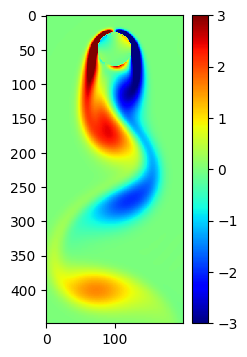

In [23]:
### Reconstructed X(t=0)
Xr = Phi @ np.diag(b) @ np.exp(omega).T
fig, ax = plt.subplots(figsize=(2.5, 4))
im = ax.imshow(
    Xr.real.reshape(height, width),
    cmap="jet",
    norm=mcolors.Normalize(vmin=-3., vmax=3.),
    interpolation='nearest'
)
plt.colorbar(im, ax=ax)

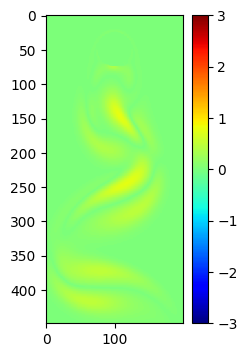

In [24]:
### Calculate the Frobenius norm of the difference from the original data.
fig, ax = plt.subplots(figsize=(2.5, 4))
im = ax.imshow(
    np.abs(Xr.real-X[:,0]).reshape(height, width),
    cmap="jet",
    norm=mcolors.Normalize(vmin=-3., vmax=3.),
    interpolation='nearest'
)
plt.colorbar(im, ax=ax)

In [25]:
num = np.linalg.norm((Xr.real-X[:,0]).reshape(height, width), 'fro')
den = np.linalg.norm(X[:,0].reshape(height, width), 'fro')
num*100/den

14.902141380647018